In [1]:
#importing all packages i need
import numpy as np
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, StandardScaler,LabelEncoder, Normalizer, PowerTransformer
import seaborn as sns 
from subprocess import check_output
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score,precision_score,precision_recall_fscore_support,recall_score,confusion_matrix,multilabel_confusion_matrix, f1_score, classification_report 
from scipy.stats import uniform
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics, tree

In [34]:
#importing my dataset
arff_file = arff.loadarff('data\speeddating.arff')
df1 = pd.DataFrame(arff_file[0])

In [35]:
# Set values greater than 1 to 1
df1.loc[df1["met"] > 1, "met"] = 1

# Set values outside of 0 and 1 to NaN
df1.loc[~df1["met"].isin([0, 1]), "met"] = np.nan


In [36]:
fields = [
    "attractive_o", "sinsere_o", "intelligence_o", 
    "funny_o", "ambitous_o", "shared_interests_o", "attractive_partner", 
    "sincere_partner", "intelligence_partner", "funny_partner", 
    "ambition_partner", "shared_interests_partner"
]

# Convert numeric fields to numeric
for field in fields:
    df1[field] = pd.to_numeric(df1[field], errors='coerce')

# Clip values to between 0 and 10
df1[fields] = df1[fields].clip(lower=0, upper=10)

print(df1.dtypes)


has_null               object
wave                  float64
gender                 object
age                   float64
age_o                 float64
                       ...   
d_guess_prob_liked     object
met                   float64
decision               object
decision_o             object
match                  object
Length: 123, dtype: object


In [37]:
#sets values outside of -1 and 1 to NaN
df1.loc[(df1["interests_correlate"] < -1) | (df1["interests_correlate"] > 1), "interests_correlate"] = np.nan

columns_to_keep = [
    "gender", "d_age", "samerace",
    "attractive_o",
    "sinsere_o", "intelligence_o", "funny_o", "ambitous_o",
    "shared_interests_o", "attractive_partner", "sincere_partner",
    "intelligence_partner", "funny_partner", "ambition_partner",
    "shared_interests_partner", "interests_correlate", "met", "match"
]
# creates new dataset as subset
df = df1[columns_to_keep]

#prints number of missing values for each variable
print(df.isna().sum())

gender                         0
d_age                          0
samerace                       0
attractive_o                 212
sinsere_o                    287
intelligence_o               306
funny_o                      360
ambitous_o                   722
shared_interests_o          1076
attractive_partner           202
sincere_partner              277
intelligence_partner         296
funny_partner                350
ambition_partner             712
shared_interests_partner    1067
interests_correlate          158
met                          375
match                          0
dtype: int64


In [38]:
# dropping some variables with large number of missing values
df = df.drop(columns=["ambitous_o","shared_interests_o", "ambition_partner","shared_interests_partner"])

#prints number of missing values for each variable
print(df.isna().sum())

gender                    0
d_age                     0
samerace                  0
attractive_o            212
sinsere_o               287
intelligence_o          306
funny_o                 360
attractive_partner      202
sincere_partner         277
intelligence_partner    296
funny_partner           350
interests_correlate     158
met                     375
match                     0
dtype: int64


In [39]:
# dropping rows with missing met values
df = df.dropna(subset=['met'])

#prints number of missing values for each variable
print(df.isna().sum())

gender                    0
d_age                     0
samerace                  0
attractive_o             79
sinsere_o               152
intelligence_o          170
funny_o                 218
attractive_partner       22
sincere_partner          89
intelligence_partner    110
funny_partner           154
interests_correlate     139
met                       0
match                     0
dtype: int64


In [40]:
# if column has missing values and is numeric, replace missing values with mean
for column in df.columns:
    if df[column].isnull().sum() > 0:
        if df[column].dtype in ['float64', 'int64']:
            df[column].fillna(df[column].mean(), inplace=True)  
            #df[column].fillna(df[column].median(), inplace=True)
            
#prints number of missing values for each variable
print(df.isna().sum())

gender                  0
d_age                   0
samerace                0
attractive_o            0
sinsere_o               0
intelligence_o          0
funny_o                 0
attractive_partner      0
sincere_partner         0
intelligence_partner    0
funny_partner           0
interests_correlate     0
met                     0
match                   0
dtype: int64


In [41]:
# creating dummy variables for categorical
df = pd.get_dummies(df, columns=['gender','samerace','met','match'], drop_first=True)

# renaming to be more descriptive
df.rename(columns={"gender_b'male'": 'gender_male'}, inplace=True)
df.rename(columns={"samerace_b'1'": 'samerace_yes'}, inplace=True)
df.rename(columns={"met_1.0": 'met_yes'}, inplace=True)
df.rename(columns={"match_b'1'": 'match_yes'}, inplace=True)

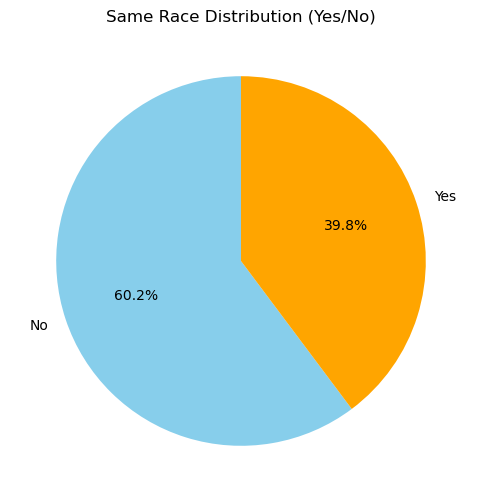

In [42]:
# pie chart for same race distribution
counts = df['samerace_yes'].value_counts() 
labels = ['Yes' if x == 1 else 'No' for x in counts.index]

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange'])
plt.title('Same Race Distribution (Yes/No)')
plt.show()


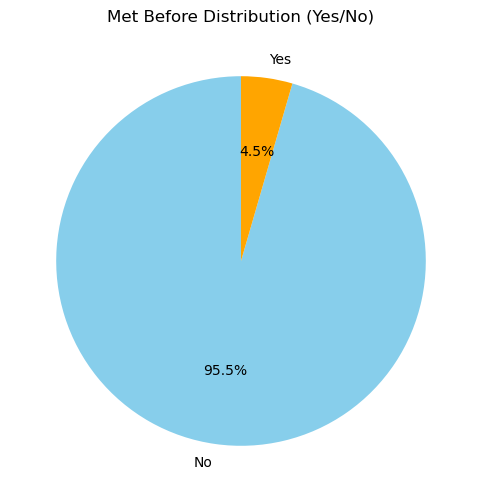

In [43]:
# pie chart for met before distribution
counts = df['met_yes'].value_counts() 
labels = ['Yes' if x == 1 else 'No' for x in counts.index]

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange'])
plt.title('Met Before Distribution (Yes/No)')
plt.show()


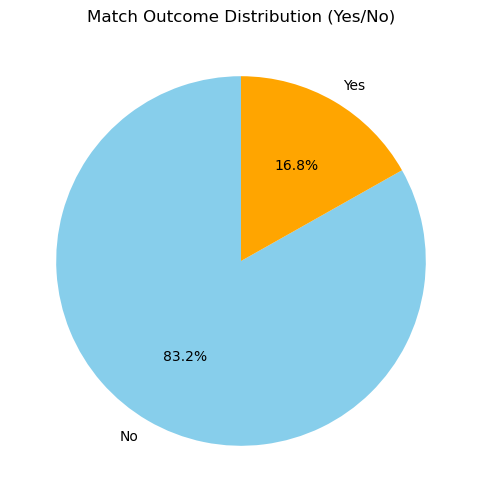

In [44]:
# pie chart for match distribution
counts = df['match_yes'].value_counts() 
labels = ['Yes' if x == 1 else 'No' for x in counts.index]

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange'])
plt.title('Match Outcome Distribution (Yes/No)')
plt.show()


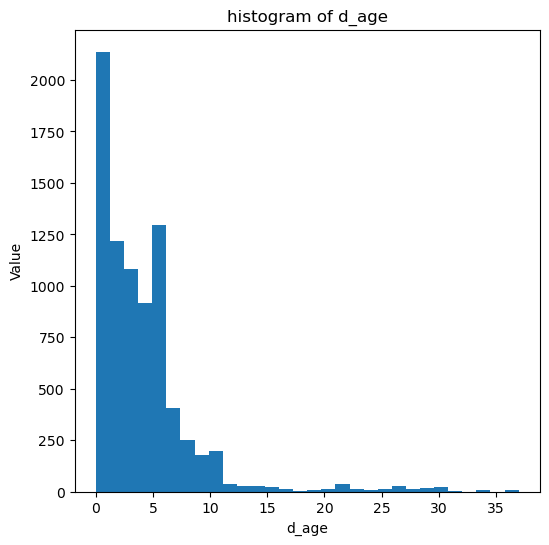

In [45]:
# histogram of d_age
plt.figure(figsize=(6, 6))
plt.hist(df["d_age"].dropna(),bins=30)
plt.title("histogram of d_age")
plt.xlabel("d_age")
plt.ylabel("Value")
plt.show()

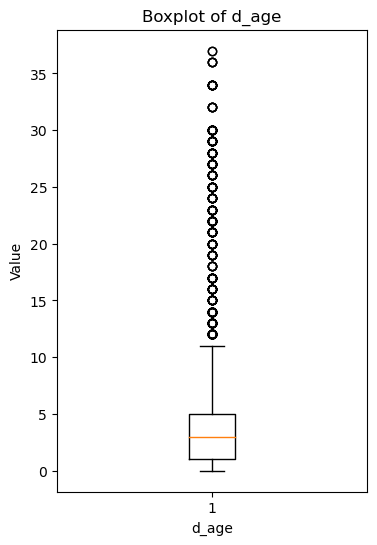

In [46]:
# boxplot of d_age
plt.figure(figsize=(4, 6))
plt.boxplot(df["d_age"].dropna())
plt.title("Boxplot of d_age")
plt.xlabel("d_age")
plt.ylabel("Value")
plt.show()

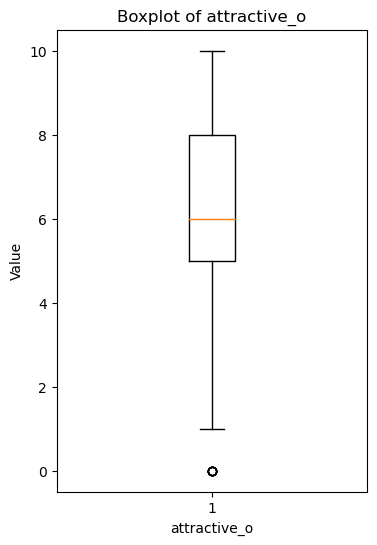

In [47]:
# boxplot of attractive_o
plt.figure(figsize=(4, 6))
plt.boxplot(df["attractive_o"].dropna())
plt.title("Boxplot of attractive_o")
plt.xlabel("attractive_o")
plt.ylabel("Value")
plt.show()

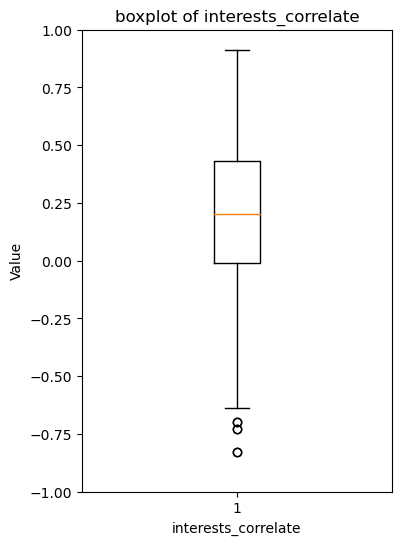

In [48]:
# boxplot of interests_correlate
plt.figure(figsize=(4, 6))
plt.boxplot(df["interests_correlate"].dropna())
plt.title("boxplot of interests_correlate")
plt.xlabel("interests_correlate")
plt.ylabel("Value")
plt.ylim(-1,1)
plt.show()

In [49]:
columns_to_standardise = [
    "d_age", "attractive_o", "sinsere_o", "intelligence_o", 
    "funny_o", "attractive_partner", 
    "sincere_partner", "intelligence_partner", "funny_partner", 
     "interests_correlate"
]

#robust_scaler = RobustScaler()
#normaliser = Normalizer()
#standard_scaler = StandardScaler()
#df["d_age"] = robust_scaler.fit_transform(df[["d_age"]])
#df[columns_to_standardise] = standard_scaler.fit_transform(df[columns_to_standardise])

# power transforming numerical variables
power_transform = PowerTransformer(method="yeo-johnson")
df[columns_to_standardise] = power_transform.fit_transform(df[columns_to_standardise])

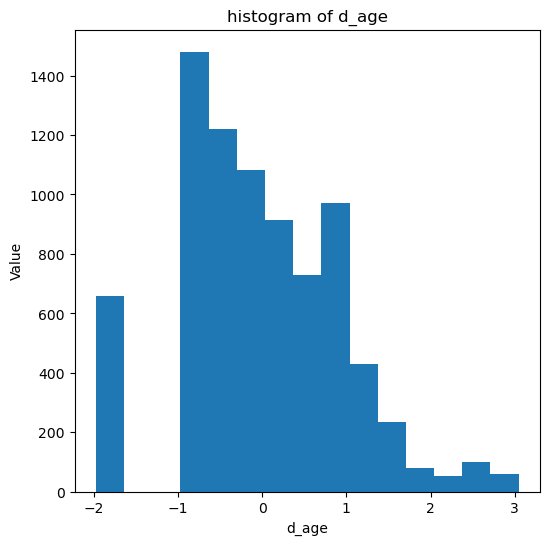

In [50]:
# histogram of d_age
plt.figure(figsize=(6, 6))
plt.hist(df["d_age"].dropna(),bins=15)
plt.title("histogram of d_age")
plt.xlabel("d_age")
plt.ylabel("Value")
plt.show()

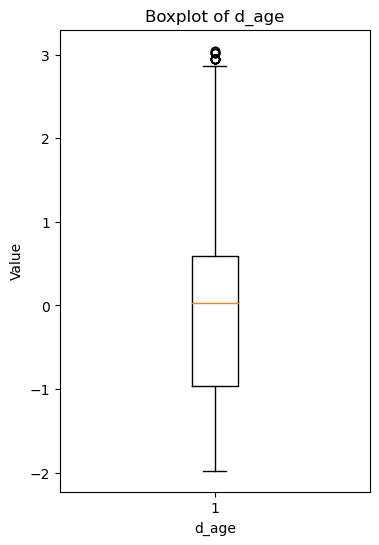

In [51]:
# boxplot of d_age
plt.figure(figsize=(4, 6))
plt.boxplot(df["d_age"].dropna())
plt.title("Boxplot of d_age")
plt.xlabel("d_age")
plt.ylabel("Value")
plt.show()

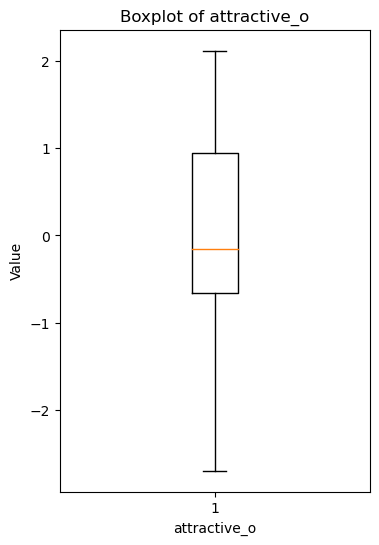

In [52]:
# boxplot of attractive_o
plt.figure(figsize=(4, 6))
plt.boxplot(df["attractive_o"].dropna())
plt.title("Boxplot of attractive_o")
plt.xlabel("attractive_o")
plt.ylabel("Value")
plt.show()

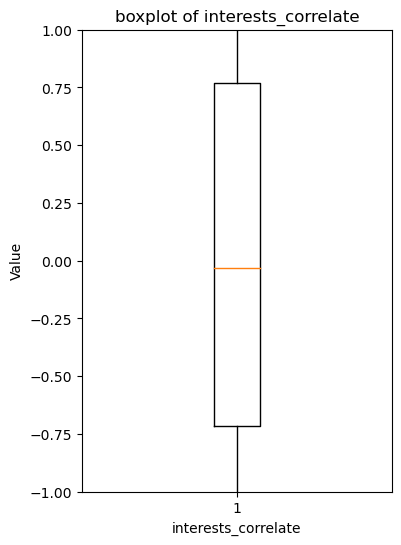

In [53]:
# boxplot of interests_correlate
plt.figure(figsize=(4, 6))
plt.boxplot(df["interests_correlate"].dropna())
plt.title("boxplot of interests_correlate")
plt.xlabel("interests_correlate")
plt.ylabel("Value")
plt.ylim(-1,1)
plt.show()

In [54]:
# check for correct numbers of unique values
print(df.nunique())

d_age                    35
attractive_o             18
sinsere_o                15
intelligence_o           18
funny_o                  17
attractive_partner       18
sincere_partner          15
intelligence_partner     18
funny_partner            17
interests_correlate     156
gender_male               2
samerace_yes              2
met_yes                   2
match_yes                 2
dtype: int64


Text(0.5, 1.0, 'Correlation between features')

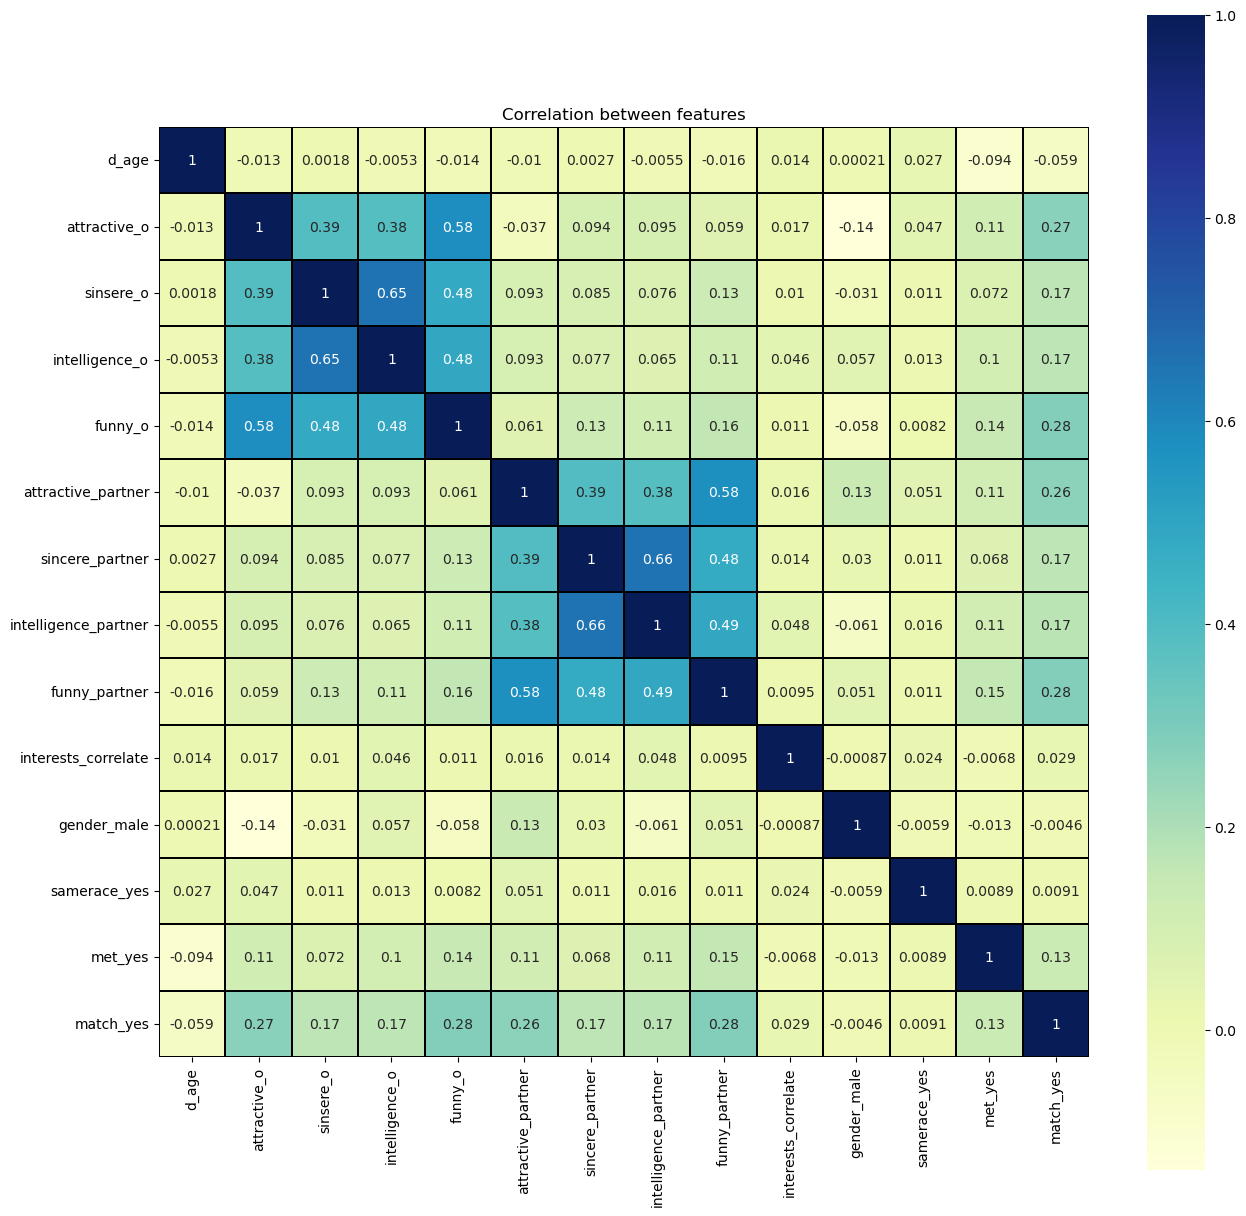

In [55]:
# correlation heat map plot for all variables
corr = df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr,vmax=1,linewidth=.01, square = True, annot = True,cmap='YlGnBu',linecolor ='black')
plt.title('Correlation between features')

In [56]:
# creating the test-train split

x=df.iloc[1:,:-1].values
y=df.iloc[1:,-1].values
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [57]:
# fitting baseline logistic regression model to data
model=LogisticRegression(max_iter=50)
model.fit(x_train,y_train)
train_score = model.score(x_train, y_train) 
test_score = model.score(x_test, y_test)    
print("Training score: {:.3f}".format(train_score)) 
print("Test score: {:.3f}".format(test_score))

# creating confusion matrix to evaluate model scores
y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
tn = cm[0, 0]
tp = cm[1, 1]
fn = cm[1, 0]
fp = cm[0, 1]

recall_score = (tp / (tp + fn))
precision_score = (tp / (tp + fp))
print('precision score is {:.2f} %'.format(precision_score*100))
print('specificity score is {:.2f} %'.format(tn / ((tn + fp))*100))
print('accuracy score is {:.2f} %'.format((tp+tn) / ((tn+tp+fn+fp))*100))

f1_1 = 2*recall_score*precision_score
f1_2 = recall_score+precision_score
f1 = f1_1/f1_2
print('F1 score is {:.2f} %'.format(f1*100))
print('recall score is {:.2f} %'.format(recall_score*100))

Training score: 0.845
Test score: 0.851
precision score is 53.40 %
specificity score is 96.46 %
accuracy score is 85.07 %
F1 score is 31.52 %
recall score is 22.36 %


In [58]:
# getting the model parameters to see which we could tune for grid search
print(model.get_params())

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 50, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [59]:
# performing a grid search
param_grid = {
    'C': [1.5,2,2.5],
    'solver': ['lbfgs', 'saga', 'liblinear'],
    'class_weight': [None, 'balanced'],
    'max_iter': [22, 23, 24, 50],
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='recall')
grid_search.fit(x_train, y_train)

print(grid_search.best_params_)
score = grid_search.score(x_train, y_train) 
print('Training score is :{:.3f}'.format(score))
score = grid_search.score(x_test,y_test)
print('Test score is :{:.3f}'.format(score))

y_pred = grid_search.predict(x_test)

# creating confusion matrix to evaluate model scores
cm = confusion_matrix(y_test, y_pred)
tn = cm[0, 0]
tp = cm[1, 1]
fn = cm[1, 0]
fp = cm[0, 1]

recall_score = (tp / (tp + fn))
precision_score = (tp / (tp + fp))
print('precision score is {:.2f} %'.format(precision_score*100))
print('specificity score is {:.2f} %'.format(tn / ((tn + fp))*100))
print('accuracy score is {:.2f} %'.format((tp+tn) / ((tn+tp+fn+fp))*100))

f1_1 = 2*recall_score*precision_score
f1_2 = recall_score+precision_score
f1 = f1_1/f1_2
print('F1 score is {:.2f} %'.format(f1*100))
print('recall score is {:.2f} %'.format(recall_score*100))

{'C': 1.5, 'class_weight': 'balanced', 'max_iter': 22, 'solver': 'lbfgs'}
Training score is :0.756
Test score is :0.768
precision score is 34.74 %
specificity score is 73.80 %
accuracy score is 74.27 %
F1 score is 47.85 %
recall score is 76.83 %


In [60]:
# fitting baseline SVM classifier model to data
model = SVC()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

score = model.score(x_train, y_train) 
print('Training score is :{:.3f}'.format(score))
score=model.score(x_test,y_test)
print('Test score is :{:.3f}'.format(score))

y_pred = model.predict(x_test)

# creating confusion matrix to evaluate model scores
cm = confusion_matrix(y_test, y_pred)
tn = cm[0, 0]
tp = cm[1, 1]
fn = cm[1, 0]
fp = cm[0, 1]

recall_score = (tp / (tp + fn))
precision_score = (tp / (tp + fp))
print('precision score is {:.2f} %'.format(precision_score*100))
print('specificity score is {:.2f} %'.format(tn / ((tn + fp))*100))
print('accuracy score is {:.2f} %'.format((tp+tn) / ((tn+tp+fn+fp))*100))

f1_1 = 2*recall_score*precision_score
f1_2 = recall_score+precision_score
f1 = f1_1/f1_2
print('F1 score is {:.2f} %'.format(f1*100))
print('recall score is {:.2f} %'.format(recall_score*100))

Training score is :0.857
Test score is :0.850
precision score is 54.41 %
specificity score is 97.71 %
accuracy score is 85.01 %
F1 score is 23.57 %
recall score is 15.04 %


In [61]:
# getting the model parameters to see which we could tune for random search
print(model.get_params())

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [ ]:
# performing a random search
param_dist = {
    'C': (0.5,1,1.5),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.01],
    'degree': [ 4, 5, 6],
    'class_weight': [None, 'balanced'],
    'tol': [1e-5, 1e-4, 1e-3],
}

randomised_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=15, cv=3, scoring=('recall'))
randomised_search.fit(x_train, y_train)

best_params_rand = randomised_search.best_params_
print(f"Best Hyperparameters: {best_params_rand}")
score = model.score(x_train, y_train) 
print('Training score is :{:.3f}'.format(score))
score=model.score(x_test,y_test)
print('Test score is :{:.3f}'.format(score))
best_model_rand = randomised_search.best_estimator_
y_pred_best_rand = best_model_rand.predict(x_test)
accuracy_best_rand = accuracy_score(y_test, y_pred_best_rand)
print("Best SVM Accuracy: {:.2f}".format(accuracy_best_rand))
y_pred = randomised_search.predict(x_test)

# creating confusion matrix to evaluate model scores
cm = confusion_matrix(y_test, y_pred)
tn = cm[0, 0]
tp = cm[1, 1]
fn = cm[1, 0]
fp = cm[0, 1]

recall_score = (tp / (tp + fn))
precision_score = (tp / (tp + fp))
print('precision score is {:.2f} %'.format(precision_score*100))
print('specificity score is {:.2f} %'.format(tn / ((tn + fp))*100))
print('accuracy score is {:.2f} %'.format((tp+tn) / ((tn+tp+fn+fp))*100))

f1_1 = 2*recall_score*precision_score
f1_2 = recall_score+precision_score
f1 = f1_1/f1_2
print('F1 score is {:.2f} %'.format(f1*100))
print('recall score is {:.2f} %'.format(recall_score*100))

In [31]:
# fitting baseline MLPC classifier model to data
model = MLPClassifier(max_iter=1000, random_state=0) 
model.fit(x_train, y_train) 
y_train_pred=model.predict(x_train)
train_score = model.score(x_train, y_train) 
test_score = model.score(x_test, y_test)    
print("Training score: {:.3f}".format(train_score)) 
print("Test score: {:.3f}".format(test_score))

y_pred = model.predict(x_test)

# creating confusion matrix to evaluate model scores
cm = confusion_matrix(y_test, y_pred)
tn = cm[0, 0]
tp = cm[1, 1]
fn = cm[1, 0]
fp = cm[0, 1]

recall_score = (tp / (tp + fn))
precision_score = (tp / (tp + fp))
print('precision score is {:.2f} %'.format(precision_score*100))
print('specificity score is {:.2f} %'.format(tn / ((tn + fp))*100))
print('accuracy score is {:.2f} %'.format((tp+tn) / ((tn+tp+fn+fp))*100))

f1_1 = 2*recall_score*precision_score
f1_2 = recall_score+precision_score
f1 = f1_1/f1_2
print('F1 score is {:.2f} %'.format(f1*100))
print('recall score is {:.2f} %'.format(recall_score*100))

Training score: 0.858
Test score: 0.845
precision score is 48.96 %
specificity score is 96.38 %
accuracy score is 84.51 %
F1 score is 27.49 %
recall score is 19.11 %


In [32]:
# getting the model parameters to see which we could tune for random search
print(model.get_params())

{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 1000, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 0, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


In [33]:
# performing a grid search
param_dist = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01],
}

grid_search = GridSearchCV(model, param_dist, cv=3, scoring='recall', n_jobs=-1)
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)
train_score = grid_search.score(x_train, y_train) 
test_score = grid_search.score(x_test, y_test)  
print("Training score: {:.3f}".format(train_score)) 
print("Test score: {:.3f}".format(test_score))

y_pred = grid_search.predict(x_test)

# creating confusion matrix to evaluate model scores
cm = confusion_matrix(y_test, y_pred)
tn = cm[0, 0]
tp = cm[1, 1]
fn = cm[1, 0]
fp = cm[0, 1]

recall_score = (tp / (tp + fn))
precision_score = (tp / (tp + fp))
print('precision score is {:.2f} %'.format(precision_score*100))
print('specificity score is {:.2f} %'.format(tn / ((tn + fp))*100))
print('accuracy score is {:.2f} %'.format((tp+tn) / ((tn+tp+fn+fp))*100))

f1_1 = 2*recall_score*precision_score
f1_2 = recall_score+precision_score
f1 = f1_1/f1_2
print('F1 score is {:.2f} %'.format(f1*100))
print('recall score is {:.2f} %'.format(recall_score*100))

{'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01, 'solver': 'adam'}
Training score: 0.435
Test score: 0.341
precision score is 46.93 %
specificity score is 92.99 %
accuracy score is 83.95 %
F1 score is 39.53 %
recall score is 34.15 %
